In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_red = pd.read_csv("winequality-red.csv", sep=';',index_col=False)
df_red['type'] = 1
df_white = pd.read_csv("winequality-white.csv", sep=';',index_col=False)
df_white['type'] = 0
df_wine = pd.concat([df_red, df_white], ignore_index=True)
X = df_wine.drop("type", axis=1)
y = df_wine["type"]

In [4]:
#misturar o df para fazer df training e test aleatorios
idx = np.arange(len(df_wine))
np.random.seed(42)
np.random.shuffle(idx)
# 80% train, 20% test
split_point = int(0.8 * len(df_wine))

train_idx = idx[:split_point]
test_idx = idx[split_point:]

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]


In [5]:

scaler = (X_train.mean(), X_train.std())

X_train_sant = (X_train- scaler[0]) / scaler[1]
X_test_sant = (X_test - scaler[0]) / scaler[1]

In [6]:
X_train_scaled  = np.asarray(X_train_sant, dtype=float)
y_train = np.asarray(y_train, dtype=float)

X_test_scaled = np.asarray(X_test_sant, dtype=float)
y_test = np.asarray(y_test, dtype=float)

In [7]:
class SVM(object):
    def __init__(self, learning_rate=1e-3, lambda_param=1e-2, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_inters = n_iters
        self.w = None
        self.b = None

    def _init_weights_bias(self, X):
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0

    def _get_cls_map(self, y):
        return np.where(y <= 0, -1, 1)

    def _satisfy_constraint(self, x, idx):
        linear_model = np.dot(x, self.w) + self.b
        return self.cls_map[idx]*linear_model >= 1
    
    def _get_gradients(self, constrain, x, idx):
         # if data point lies on the correct side
        if constrain:
            dw = self.lambda_param * self.w
            db = 0
            return dw, db
        # if data point is on the wrong side
        dw = self.lambda_param * self.w - np.dot(self.cls_map[idx], x)
        db = - self.cls_map[idx]
        return dw, db
    
    def _update_weights_bias(self, dw, db):
        self.w -= self.lr*dw
        self.b -= self.lr*db
    
    def fit(self, X, y):
        self._init_weights_bias(X)
        self.cls_map = self._get_cls_map(y)
        for _ in range(self.n_inters):
            for idx, x in enumerate(X):
                # check if data point satisfies the constraint
                constrain = self._satisfy_constraint(x, idx)
                # compute the gradients accordingly
                dw, db = self._get_gradients(constrain, x, idx)
                self._update_weights_bias(dw, db)

    
    def predict(self, X):
        estimate = np.dot(X, self.w) + self.b
        prediction = np.sign(estimate)
        # prediction in the original values
        return np.where(prediction == -1, 0, 1)



SVM Linear Accuracy:  0.9946153846153846


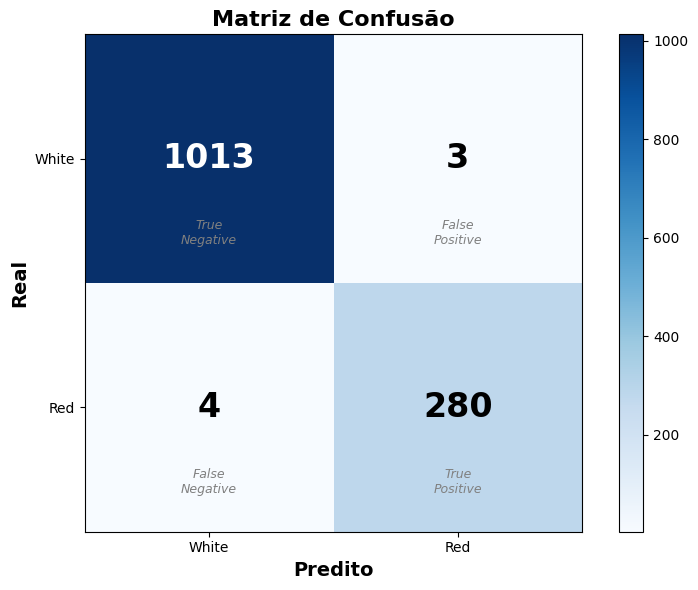

In [9]:
svm = SVM(n_iters=1000)
svm.fit(X_train_scaled, y_train)
predictions = svm.predict(X_test_scaled)
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true==y_pred) / len(y_true)
    return accuracy
def confusion_matrix(y_true, y_pred, class_names=['White', 'Red']):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 0) & (y_pred == 1))
    TP = np.sum((y_true==1) & (y_pred==1))
    FP = np.sum((y_true==1)&(y_pred==0))
    matrix = np.array([[TN, FP], [FN, TP]])
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar(im, ax=ax)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    ax.set_xlabel('Predito', fontsize=14, fontweight='bold')
    ax.set_ylabel('Real', fontsize=14, fontweight='bold')
    ax.set_title('Matriz de Confusão', fontsize=16, fontweight='bold')
    
    
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, matrix[i, j],
                          ha="center", va="center", color="white" if matrix[i, j] > matrix.max()/2 else "black",
                          fontsize=24, fontweight='bold')
    
    labels = [['True\nNegative', 'False\nPositive'],
              ['False\nNegative', 'True\nPositive']]
    
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i+0.3, labels[i][j],
                          ha="center", va="center", color="gray",
                          fontsize=9, style='italic')
    
    plt.tight_layout()
    return 
print("SVM Linear Accuracy: ", accuracy(y_test, predictions))
confusion_matrix(y_test, predictions)